# Projected Change in Heating Degree Days by Alaska Native Corporation

This notebook demonstrates how to query the SNAP Data API for Alaska Native Corporation polygons, Alaska communities, and modeled heating degree days. In this example, we use ARDAC helper functions from the ```ardac_utils.py``` module to quickly fetch and summarize these datasets.

Mean heating degree days for each Alaska Native Corporation area are computed by averaging the heating degree days in each community that falls within the corporation bounds. This sampling design uses the coordinates of places where people actually live to get values for heating degree days, rather than a zonal mean across the entire polygon which may include uninhabited areas with extreme climates (eg, Denali).

We then query the [US Census API](https://www.census.gov/data/developers/data-sets.html) to get population estimates for each Alaska Native Corporation area. This adds some context to the dataset, and since the Alaska Native Corporation areas tend to enclose regions with similar climatic conditions, this allows us to compute [population-weighted heating degree days](https://www.eia.gov/tools/glossary/index.php?id=Population-weighted%20Degree%20Days) value for the entire state. 

### Setup:

Import python packages and all functions from the ```ardac_utils.py``` module.

In [16]:
from ardac_utils import *
import aiohttp
import requests
import matplotlib.pyplot as plt
import numpy as np

### Fetch points and polygons using the SNAP Data API

Use the ```get_area_gdf_by_category()``` and ```get_point_gdf_by_category()``` helper functions to fetch Alaska Native Corporation and Alaska communities GeoJSON polygons/points from the SNAP Data API and convert them to geodataframe objects. 

The category string that we pass to these functions is identical to the endpoint URL found in the [documentation](https://earthmaps.io/boundary/) for the physical and administrative boundary datasets. For example, if one would use ```earthmaps.io/places/corporations``` to get Alaska Native Corporation data, we can pass the last part of this URL (```"corporations"```) as input to the helper function.

In [17]:
nc_gdf = get_area_gdf_by_category("corporations")

places_gdf = get_point_gdf_by_category("communities")
#limit to only US places
places_gdf = places_gdf[places_gdf['country'] == 'US'].copy()

### Join polygons to communities

Perform a spatial join to find all communities that are contained within each Alaska Native Corporation polygon. All attributes of the two geodataframes will be preserved.

In [18]:
results = gpd.sjoin(nc_gdf, places_gdf, how='left', predicate="contains").reset_index().dropna()
print(results)

     index id_left              name_left  \
0        0     NC1    Ahtna, Incorporated   
1        0     NC1    Ahtna, Incorporated   
2        0     NC1    Ahtna, Incorporated   
3        0     NC1    Ahtna, Incorporated   
4        0     NC1    Ahtna, Incorporated   
..     ...     ...                    ...   
519      0    NC12  The Aleut Corporation   
520      0    NC12  The Aleut Corporation   
521      0    NC12  The Aleut Corporation   
522      0    NC12  The Aleut Corporation   
523      0    NC12  The Aleut Corporation   

                                              the_geom  index_right id_right  \
0    MULTIPOLYGON (((-144.17464 63.11695, -143.7954...          239    AK240   
1    MULTIPOLYGON (((-144.17464 63.11695, -143.7954...           67     AK73   
2    MULTIPOLYGON (((-144.17464 63.11695, -143.7954...          231    AK232   
3    MULTIPOLYGON (((-144.17464 63.11695, -143.7954...          402    AK403   
4    MULTIPOLYGON (((-144.17464 63.11695, -143.7954...     

### Get projected heating degree days using the SNAP Data API

Using the community latitudes and longitudes and a list of decadal start/end years, we can construct URLs that will be used to fetch heating degree days data from the SNAP Data API. According to the degree days endpoint [documentation](https://earthmaps.io/degree_days/#:~:text=Degree%20days%20across%20provided%20year%20range%20(point%20query)), we can request projected heating degree days using the following endpoint construction:

```earthmaps.io/degree_days/heating/<latitude>/<longitude>/<start_year>/<end_year>```

Since we need to make a separate request for each community/decade combination, we will use an ```aiohttp``` session to make simultaneous requests from the API. This will dramatically improve the speed of this operation. The code below opens a session, then iterates through the ```results``` geodataframe to fetch heating degree days data and populate the empty columns of the geodataframe with the parsed JSON response. 

_**Note:** An error message is included to identify any communities without heating degree days data. These are most often found in coastal areas where the base dataset is too coarse to accurately depict the coastline, and as a result the coordinates of these communties appear to exist in the ocean. For our purposes, we will leave these communities out of our analysis, but including this type of error message is a best practice in case one wants to manually adjust the community coordinates in an inland direction to capture more heating degree days data._

In [19]:
decades = [['2020', '2030'], ['2030', '2040'], ['2040', '2050']]
decades_cols = ['heating_dd_2020-2030','heating_dd_2030-2040','heating_dd_2040-2050']
for new_col_name in decades_cols:
    results[new_col_name] = None

async with aiohttp.ClientSession() as s:
    for index, row in results.iterrows():
        lat = row.latitude
        lon = row.longitude
        for d, c in zip(decades,decades_cols):
            url = str('https://earthmaps.io/degree_days/heating/' + str(lat) + "/" + str(lon) + "/" + d[0] + "/" + d[1] + "?summarize=mmm")
            async with s.get(url) as response:
                if response.status != 200:
                    print("no data returned for " + row['name_right'] + ": " + str(lat) + ", " + str(lon))
                else:
                    dd_json = await response.json()
                    dd_mean = dd_json['projected']['ddmean']
                    results.iloc[index, results.columns.get_loc(c)] = dd_mean

no data returned for Kaktovik: 70.1131, -143.6623
no data returned for Kaktovik: 70.1131, -143.6623
no data returned for Kaktovik: 70.1131, -143.6623
no data returned for King Island: 64.9694, -168.065
no data returned for King Island: 64.9694, -168.065
no data returned for King Island: 64.9694, -168.065
no data returned for Diomede: 65.7648, -168.911
no data returned for Diomede: 65.7648, -168.911
no data returned for Diomede: 65.7648, -168.911
no data returned for Chiniak: 57.617, -152.2166
no data returned for Chiniak: 57.617, -152.2166
no data returned for Chiniak: 57.617, -152.2166
no data returned for Port Alexander: 56.2497, -134.644
no data returned for Port Alexander: 56.2497, -134.644
no data returned for Port Alexander: 56.2497, -134.644
no data returned for Chiniak: 57.617, -152.2166
no data returned for Chiniak: 57.617, -152.2166
no data returned for Chiniak: 57.617, -152.2166
no data returned for Port Alexander: 56.2497, -134.644
no data returned for Port Alexander: 56.24

View the heating degree days that have been added to the results table.

In [20]:
print(results)

     index id_left              name_left  \
0        0     NC1    Ahtna, Incorporated   
1        0     NC1    Ahtna, Incorporated   
2        0     NC1    Ahtna, Incorporated   
3        0     NC1    Ahtna, Incorporated   
4        0     NC1    Ahtna, Incorporated   
..     ...     ...                    ...   
519      0    NC12  The Aleut Corporation   
520      0    NC12  The Aleut Corporation   
521      0    NC12  The Aleut Corporation   
522      0    NC12  The Aleut Corporation   
523      0    NC12  The Aleut Corporation   

                                              the_geom  index_right id_right  \
0    MULTIPOLYGON (((-144.17464 63.11695, -143.7954...          239    AK240   
1    MULTIPOLYGON (((-144.17464 63.11695, -143.7954...           67     AK73   
2    MULTIPOLYGON (((-144.17464 63.11695, -143.7954...          231    AK232   
3    MULTIPOLYGON (((-144.17464 63.11695, -143.7954...          402    AK403   
4    MULTIPOLYGON (((-144.17464 63.11695, -143.7954...     

### Calculate mean heating degree days

Group the results table using the name of the Alaska Native Corporations, and calculate the mean heating degree days of each decade for each group. Remember that the resulting value represents heating degree days in the populated places within each corporation boundary, and is not a mean across the total area.

In [21]:
nc_dd_mean = results.groupby('name_left', as_index=False)[['heating_dd_2020-2030', 'heating_dd_2030-2040', 'heating_dd_2040-2050']].mean()
print(nc_dd_mean)

                            name_left heating_dd_2020-2030  \
0                 Ahtna, Incorporated          13410.47619   
1   Arctic Slope Regional Corporation         15988.454545   
2   Bering Straits Native Corporation         12727.952381   
3      Bristol Bay Native Corporation          9597.189189   
4                 Calista Corporation         10274.368852   
5          Chugach Alaska Corporation          9792.464286   
6     Cook Inlet Region, Incorporated              10470.5   
7                      Doyon, Limited         13154.311111   
8                Koniag, Incorporated              8509.75   
9           NANA Regional Corporation         13861.384615   
10               Sealaska Corporation          7679.388889   
11              The Aleut Corporation          7544.592593   

   heating_dd_2030-2040 heating_dd_2040-2050  
0          13159.190476          12380.47619  
1          15260.090909         14031.727273  
2          12305.333333          11220.47619  
3    

### Fetch and join population data

Using the US Census API, we can quickly fetch some population data to join to the mean heating degree days results. The URL string below fetches the American Communities Survey 5-year population estimates for years 2017-2021. (See the [US Census API documentation](https://www.census.gov/data/developers/data-sets/acs-5year.html) and their ACS5 dataset [examples](https://api.census.gov/data/2021/acs/acs5/examples.html
) to find out more details on how this URL was constructed.)

Here, we use the standard ```requests``` package since we are only making one request. Again we include an error message in case no data is returned.

In [22]:
url = 'https://api.census.gov/data/2021/acs/acs5?get=NAME,B01001_001E&for=alaska%20native%20regional%20corporation:*'

with requests.Session() as s:
    census_response = s.get(url)
    if census_response.status_code != 200:
            print("No data returned.")
    else:
        census_data = pd.DataFrame(columns=['name', 'pop'])
        for r in census_response.json()[1:]:
            n = r[0]
            p = r[1]
            ix = len(census_data)+1
            census_data.loc[ix, 'name'] = n
            census_data.loc[ix, 'pop'] = p

print(census_data)

                                                 name     pop
1    Ahtna Alaska Native Regional Corporation, Alaska    2846
2    Aleut Alaska Native Regional Corporation, Alaska    8660
3   Arctic Slope Alaska Native Regional Corporatio...   10865
4   Bering Straits Alaska Native Regional Corporat...   10070
5   Bristol Bay Alaska Native Regional Corporation...    6618
6   Calista Alaska Native Regional Corporation, Al...   26868
7   Chugach Alaska Native Regional Corporation, Al...   11582
8   Cook Inlet Alaska Native Regional Corporation,...  453589
9    Doyon Alaska Native Regional Corporation, Alaska  111430
10  Koniag Alaska Native Regional Corporation, Alaska   13218
11    NANA Alaska Native Regional Corporation, Alaska    7776
12  Sealaska Alaska Native Regional Corporation, A...   70984


Notice how the census corporation names do not exactly match the names in our dataset. We will have to manually add the population numbers in the correct order to match them up. For a larger dataset, it would be faster to employ a fuzzy matching algorithm to do this for us, but in this case it is simpler to rearrange the population numbers into a new table and join a new column in the results table.

In [23]:
corps = list(nc_dd_mean.name_left.unique())
pops_sorted = [2846,
               10865,
               10070,
               6618,
               26868,
               11582,
               453589,
               111430,
               13218,
               7776,
               70984,
               8660, ### << this is the only value that needed to be moved...otherwise the corps are alphabetical
               ]

pop_df = pd.DataFrame(list(zip(corps, pops_sorted)), columns =['name', 'pop'])
nc_dd_mean_pop = nc_dd_mean.merge(pop_df, how='left', left_on='name_left', right_on='name')
print(nc_dd_mean_pop)

                            name_left heating_dd_2020-2030  \
0                 Ahtna, Incorporated          13410.47619   
1   Arctic Slope Regional Corporation         15988.454545   
2   Bering Straits Native Corporation         12727.952381   
3      Bristol Bay Native Corporation          9597.189189   
4                 Calista Corporation         10274.368852   
5          Chugach Alaska Corporation          9792.464286   
6     Cook Inlet Region, Incorporated              10470.5   
7                      Doyon, Limited         13154.311111   
8                Koniag, Incorporated              8509.75   
9           NANA Regional Corporation         13861.384615   
10               Sealaska Corporation          7679.388889   
11              The Aleut Corporation          7544.592593   

   heating_dd_2030-2040 heating_dd_2040-2050  \
0          13159.190476          12380.47619   
1          15260.090909         14031.727273   
2          12305.333333          11220.47619   
3

### Plot Mean Heating Degree Days by AK Native Corporation and Population:

Sort the final dataframe by population to better organize the plot. Combine the corporation name and population into one column to label the X axis, then plot each decade as separately spaced bars. 

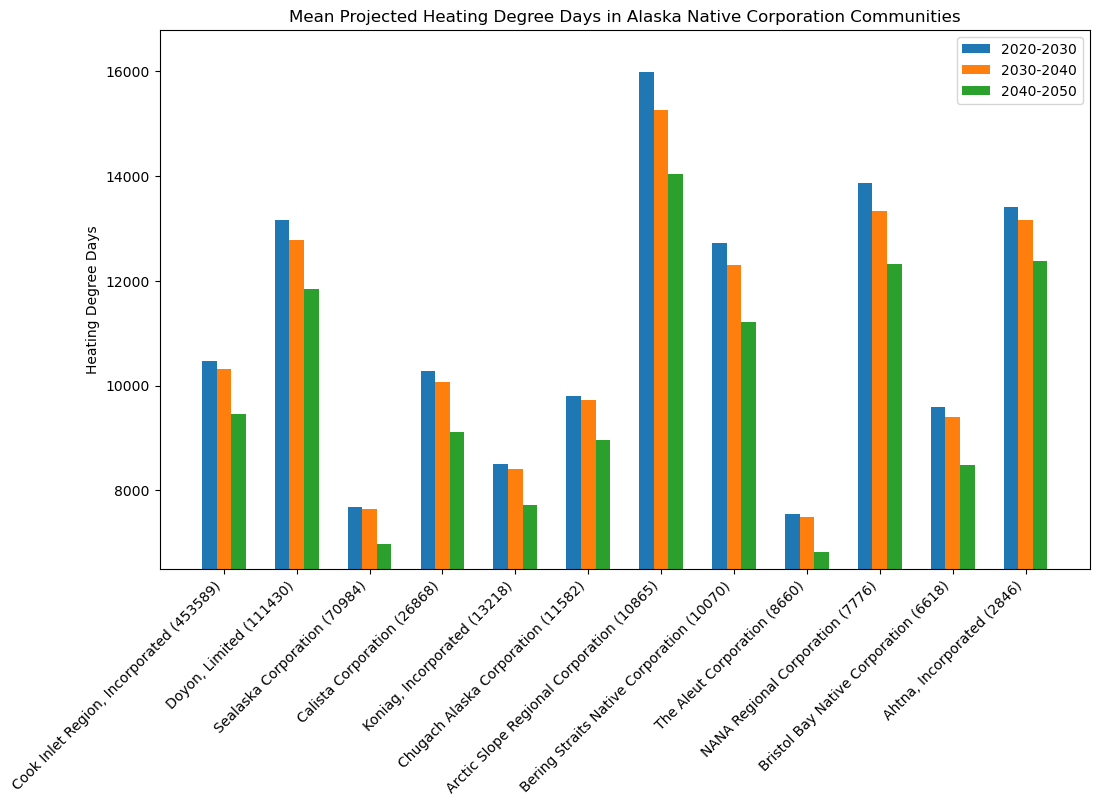

In [24]:
nc_dd_mean_pop.sort_values(by='pop', ascending=False, inplace=True)
nc_dd_mean_pop['labels'] = None
for index, row in nc_dd_mean_pop.iterrows():
    nc_dd_mean_pop.loc[index, 'labels'] = str(row['name'] + " (" + str(row['pop']) + ")")

x = nc_dd_mean_pop["labels"]
y1 = nc_dd_mean_pop["heating_dd_2020-2030"]
y2 = nc_dd_mean_pop["heating_dd_2030-2040"]
y3 = nc_dd_mean_pop["heating_dd_2040-2050"]
  
x_axis = np.arange(len(x))

plt.figure(figsize=(12,7)) 

plt.bar(x_axis - 0.2, y1, 0.2, label = '2020-2030') 
plt.bar(x_axis + 0.0, y2, 0.2, label = '2030-2040')
plt.bar(x_axis + 0.2, y3, 0.2, label = '2040-2050') 
  
plt.xticks(x_axis, x, rotation=45, ha='right') 
plt.ylim(ymin=6500)
plt.ylabel("Heating Degree Days") 
plt.title("Mean Projected Heating Degree Days in Alaska Native Corporation Communities") 
plt.legend() 
plt.show() 

### Statewide Population-Weighted Heating Degree Days

Finally, let's use the populations for each Alaska Native Corporation region to calculate population-weighted projected heating degree days for each decade. Note that this calculation makes the assumption that the climatic conditions in each region are somewhat homogenous.

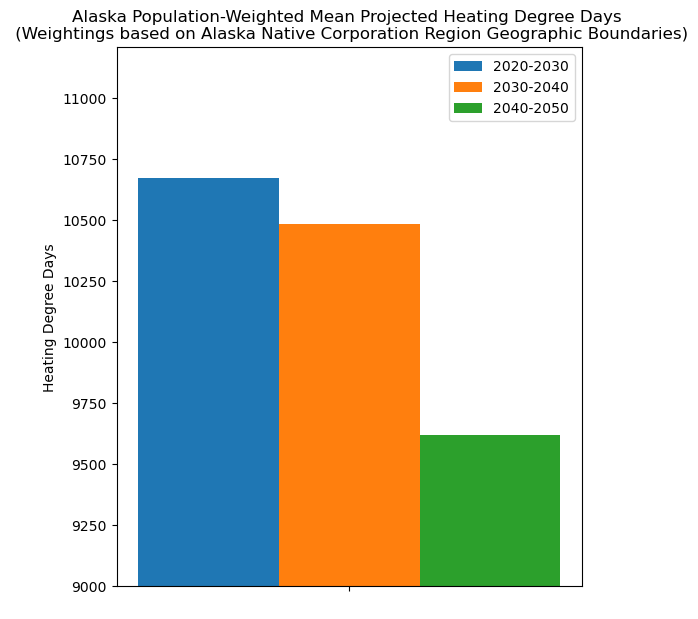

In [25]:
total_pop = sum(nc_dd_mean_pop['pop'])

x = [" "]
y1 = sum(nc_dd_mean_pop['heating_dd_2020-2030'] * nc_dd_mean_pop['pop']) / total_pop
y2 = sum(nc_dd_mean_pop['heating_dd_2030-2040'] * nc_dd_mean_pop['pop']) / total_pop
y3 = sum(nc_dd_mean_pop['heating_dd_2040-2050'] * nc_dd_mean_pop['pop']) / total_pop

x_axis = np.arange(len(x))

plt.figure(figsize=(6,7)) 

plt.bar(x_axis - 0.01, y1, 0.01, label = '2020-2030') 
plt.bar(x_axis + 0.0, y2, 0.01, label = '2030-2040')
plt.bar(x_axis + 0.01, y3, 0.01, label = '2040-2050') 
  
plt.xticks(x_axis, x, rotation=45, ha='right') 
plt.ylim(ymin=9000)
plt.ylabel("Heating Degree Days") 
plt.title("Alaska Population-Weighted Mean Projected Heating Degree Days \n (Weightings based on Alaska Native Corporation Region Geographic Boundaries)") 
plt.legend() 
plt.show() 